In [1]:
#Author     : Fan Li
#Update Date: 01/10/2022
#Version    : 3.0

#Intrusion Detection System Using Machine Learning (Cat Boost)

#Original Data (cic ids 2017)

#hardware
#12vCPUs | 48GiB | c7.3xlarge.4

#System
#Ubuntu 20.04 server 64bit

In [2]:
#1. Loading Module
#basic
import os
os.environ['OPENBLAS_NUM_THREADS'] = '1'
import gc    #memory manage

import math
import numpy as np
import pandas as pd

#draw figure
import seaborn as sns
import matplotlib.pyplot as plt

#preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from collections import Counter

#Feature Selection

from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

#model
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.neighbors import KNeighborsClassifier


from catboost import CatBoostClassifier
#metrics

from sklearn import model_selection,feature_selection,utils,ensemble,metrics

#time
from time import time
import datetime

In [3]:
#2. Reading Dataset
base_path="../../data/"
# Monday benign
f1_path=base_path+"Monday-WorkingHours.pcap_ISCX.csv"
f1=pd.read_csv(f1_path)
#Tuesday benign
f2_path=base_path+"Tuesday-WorkingHours.pcap_ISCX.csv"
f2=pd.read_csv(f2_path)
#Wed benign
f3_path=base_path+"Wednesday-workingHours.pcap_ISCX.csv"
f3=pd.read_csv(f3_path)
#Thur WebAttack
f4_path1=base_path+"Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv"
f41=pd.read_csv(f4_path1)
f4_path2=base_path+"Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv"
f42=pd.read_csv(f4_path2)
#Fri Benign DDos PortScan
f5_path1=base_path+"Friday-WorkingHours-Morning.pcap_ISCX.csv"
f51=pd.read_csv(f5_path1)

f5_path2=base_path+"Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv"
f52=pd.read_csv(f5_path2)

f5_path3=base_path+"Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv"
f53=pd.read_csv(f5_path3)

In [4]:
data=pd.concat((f1,f2,f3,f41,f42,f51,f52,f53))
data.reset_index(inplace=True,drop=True) # duplicate index exist, reset index
data.shape

(2830743, 79)

In [5]:
data

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,49188,4,2,0,12,0,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
1,49188,1,2,0,12,0,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2,49188,1,2,0,12,0,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
3,49188,1,2,0,12,0,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
4,49486,3,2,0,12,0,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2830738,61374,61,1,1,6,6,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2830739,61378,72,1,1,6,6,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2830740,61375,75,1,1,6,6,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2830741,61323,48,2,0,12,0,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN


In [6]:
# too few samples in some subclasses of Web Attack, and they are combined into one class.
#Tuesday Brute Force
data[' Label'].replace("FTP-Patator","BruteForce",inplace=True,regex=True)
data[' Label'].replace("SSH-Patator","BruteForce",inplace=True,regex=True)
#Thursday Web Attack
data[' Label'].replace("Web Attack .*","Web Attack",inplace=True,regex=True)
#DoS 
data[' Label'].replace("DoS .*","DoS",inplace=True,regex=True)
data[' Label'].replace("DDoS","DoS",inplace=True,regex=True)

In [7]:
target_count_new=data[' Label'].value_counts(0)
target_count_new

BENIGN          2273097
DoS              380688
PortScan         158930
BruteForce        13835
Web Attack         2180
Bot                1966
Infiltration         36
Heartbleed           11
Name:  Label, dtype: int64

In [8]:
labels_new,values_new=zip(*sorted(target_count_new.items()))

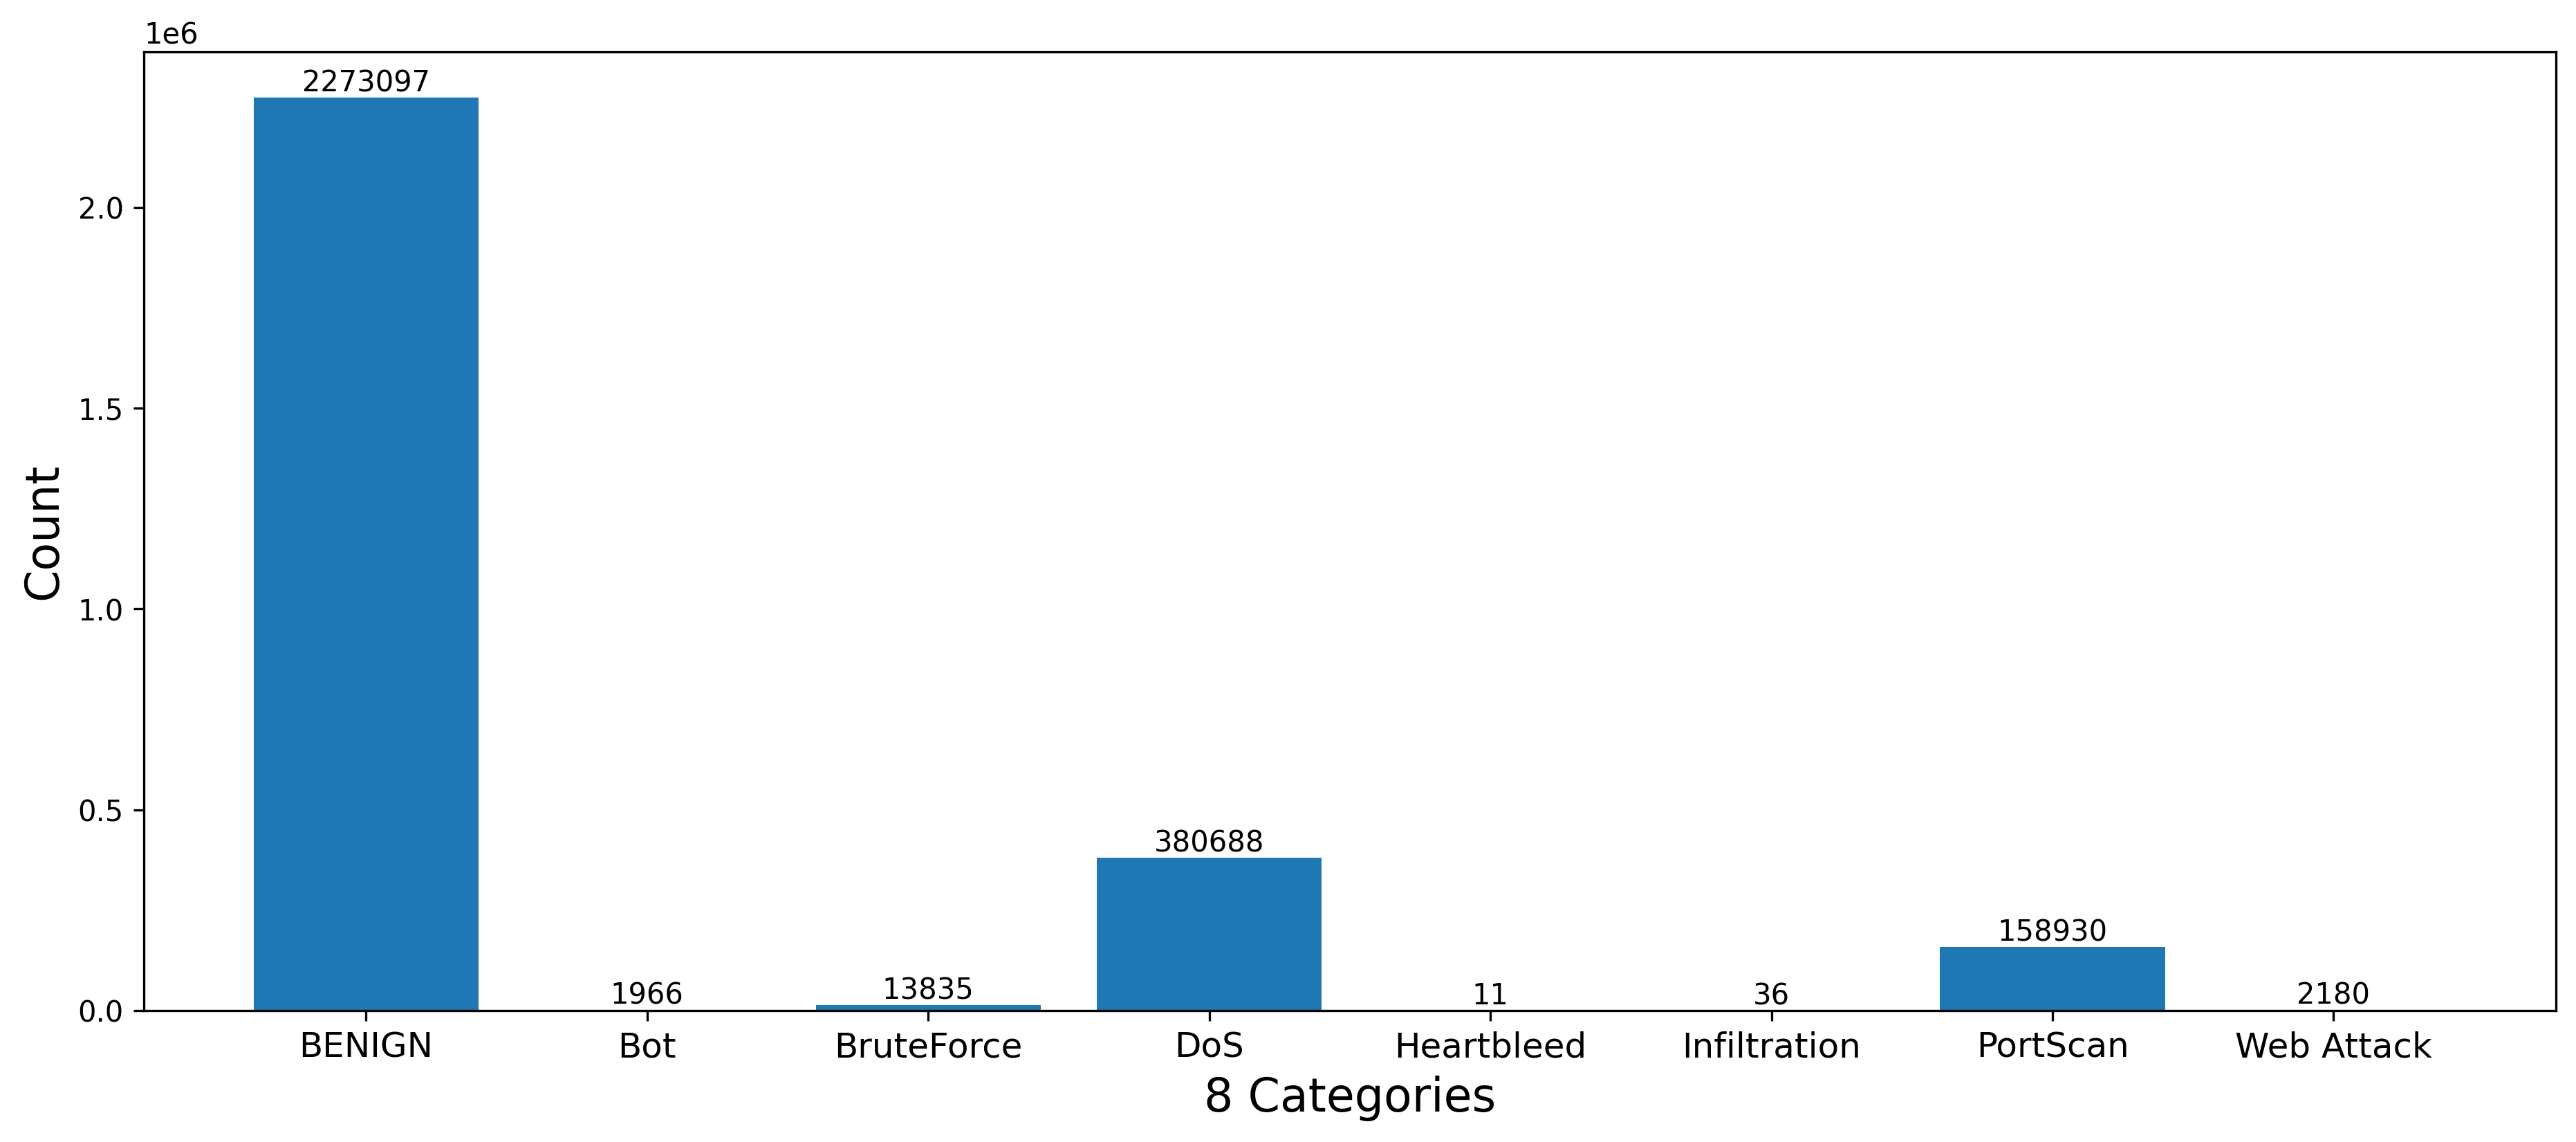

In [9]:
plt.figure(dpi=300,figsize=(15,6))
plt.bar(labels_new,values_new)
for x_new,y_new in zip(labels_new,values_new):
    plt.text(x_new,y_new,y_new,ha="center",va="bottom")
plt.xticks(fontsize=12,rotation=0)
plt.xlabel("8 Categories",fontsize=16)
plt.ylabel("Count",fontsize=16)
plt.show()

In [10]:
#3. Preprocessing
#3.1 remove useless data
#remove duplicate row
data=data.drop_duplicates()
#remove rows with null value and infinite value
data=data.replace(np.inf,np.nan)
data=data.dropna()

In [11]:
data[' Label'].value_counts()

BENIGN          2072476
DoS              321759
PortScan          90694
BruteForce         9150
Web Attack         2143
Bot                1948
Infiltration         36
Heartbleed           11
Name:  Label, dtype: int64

In [12]:
X=data.iloc[:,:-1]
y=data.iloc[:,-1]
print(Counter(y))

Counter({'BENIGN': 2072476, 'DoS': 321759, 'PortScan': 90694, 'BruteForce': 9150, 'Web Attack': 2143, 'Bot': 1948, 'Infiltration': 36, 'Heartbleed': 11})


In [13]:
#Label Encoding
le=LabelEncoder()
le=le.fit(y)
le.classes_
y=le.transform(y)
print(Counter(y))

Counter({0: 2072476, 3: 321759, 6: 90694, 2: 9150, 7: 2143, 1: 1948, 5: 36, 4: 11})


In [14]:
#Ram Clean
del data
gc.collect()

3692

In [15]:
#3.2 Splitting data
X_train,X_test,y_train,y_test=model_selection.train_test_split(X,y,test_size=0.33,random_state=123456)

In [16]:
print(Counter(y_train))

Counter({0: 1388615, 3: 215467, 6: 60860, 2: 6100, 7: 1440, 1: 1293, 5: 20, 4: 10})


In [17]:
#4. Training
clf=CatBoostClassifier(random_state=12345)

In [18]:
time1=time()
clf.fit(X_train,y_train)
print("Time of Training : {:.3f} s".format(time()-time1))

Learning rate set to 0.11554
0:	learn: 1.3602636	total: 652ms	remaining: 10m 51s
1:	learn: 1.0622802	total: 1.29s	remaining: 10m 42s
2:	learn: 0.8690210	total: 1.86s	remaining: 10m 18s
3:	learn: 0.7303952	total: 2.43s	remaining: 10m 5s
4:	learn: 0.6235124	total: 3s	remaining: 9m 57s
5:	learn: 0.5377481	total: 3.58s	remaining: 9m 54s
6:	learn: 0.4670268	total: 4.14s	remaining: 9m 47s
7:	learn: 0.4081127	total: 4.76s	remaining: 9m 49s
8:	learn: 0.3588543	total: 5.32s	remaining: 9m 46s
9:	learn: 0.3176969	total: 5.89s	remaining: 9m 43s
10:	learn: 0.2809550	total: 6.48s	remaining: 9m 42s
11:	learn: 0.2504695	total: 7.07s	remaining: 9m 42s
12:	learn: 0.2239720	total: 7.64s	remaining: 9m 40s
13:	learn: 0.2000762	total: 8.14s	remaining: 9m 33s
14:	learn: 0.1797548	total: 8.63s	remaining: 9m 26s
15:	learn: 0.1620062	total: 9.16s	remaining: 9m 23s
16:	learn: 0.1466436	total: 9.67s	remaining: 9m 18s
17:	learn: 0.1329213	total: 10.2s	remaining: 9m 16s
18:	learn: 0.1202275	total: 10.8s	remaining: 

157:	learn: 0.0051229	total: 1m 20s	remaining: 7m 10s
158:	learn: 0.0051094	total: 1m 21s	remaining: 7m 9s
159:	learn: 0.0050990	total: 1m 21s	remaining: 7m 9s
160:	learn: 0.0050911	total: 1m 22s	remaining: 7m 8s
161:	learn: 0.0050724	total: 1m 22s	remaining: 7m 7s
162:	learn: 0.0050436	total: 1m 23s	remaining: 7m 7s
163:	learn: 0.0050357	total: 1m 23s	remaining: 7m 6s
164:	learn: 0.0050235	total: 1m 24s	remaining: 7m 5s
165:	learn: 0.0050100	total: 1m 24s	remaining: 7m 4s
166:	learn: 0.0049945	total: 1m 25s	remaining: 7m 4s
167:	learn: 0.0049546	total: 1m 25s	remaining: 7m 4s
168:	learn: 0.0049465	total: 1m 26s	remaining: 7m 3s
169:	learn: 0.0048979	total: 1m 26s	remaining: 7m 3s
170:	learn: 0.0048892	total: 1m 26s	remaining: 7m 1s
171:	learn: 0.0048550	total: 1m 27s	remaining: 7m 1s
172:	learn: 0.0048320	total: 1m 28s	remaining: 7m
173:	learn: 0.0048165	total: 1m 28s	remaining: 7m
174:	learn: 0.0047970	total: 1m 29s	remaining: 6m 59s
175:	learn: 0.0047590	total: 1m 29s	remaining: 6m 

311:	learn: 0.0037309	total: 2m 35s	remaining: 5m 43s
312:	learn: 0.0037281	total: 2m 36s	remaining: 5m 42s
313:	learn: 0.0037269	total: 2m 36s	remaining: 5m 42s
314:	learn: 0.0037253	total: 2m 37s	remaining: 5m 41s
315:	learn: 0.0037230	total: 2m 37s	remaining: 5m 41s
316:	learn: 0.0037218	total: 2m 38s	remaining: 5m 40s
317:	learn: 0.0037173	total: 2m 38s	remaining: 5m 40s
318:	learn: 0.0037161	total: 2m 39s	remaining: 5m 39s
319:	learn: 0.0037073	total: 2m 39s	remaining: 5m 39s
320:	learn: 0.0037006	total: 2m 40s	remaining: 5m 38s
321:	learn: 0.0036987	total: 2m 40s	remaining: 5m 38s
322:	learn: 0.0036961	total: 2m 40s	remaining: 5m 37s
323:	learn: 0.0036951	total: 2m 41s	remaining: 5m 36s
324:	learn: 0.0036848	total: 2m 41s	remaining: 5m 36s
325:	learn: 0.0036796	total: 2m 42s	remaining: 5m 35s
326:	learn: 0.0036711	total: 2m 42s	remaining: 5m 35s
327:	learn: 0.0036650	total: 2m 43s	remaining: 5m 35s
328:	learn: 0.0036628	total: 2m 44s	remaining: 5m 34s
329:	learn: 0.0036616	total:

464:	learn: 0.0032994	total: 3m 49s	remaining: 4m 23s
465:	learn: 0.0032973	total: 3m 50s	remaining: 4m 23s
466:	learn: 0.0032958	total: 3m 50s	remaining: 4m 22s
467:	learn: 0.0032935	total: 3m 50s	remaining: 4m 22s
468:	learn: 0.0032924	total: 3m 51s	remaining: 4m 21s
469:	learn: 0.0032900	total: 3m 51s	remaining: 4m 21s
470:	learn: 0.0032892	total: 3m 52s	remaining: 4m 20s
471:	learn: 0.0032883	total: 3m 52s	remaining: 4m 20s
472:	learn: 0.0032872	total: 3m 53s	remaining: 4m 19s
473:	learn: 0.0032861	total: 3m 53s	remaining: 4m 19s
474:	learn: 0.0032857	total: 3m 54s	remaining: 4m 18s
475:	learn: 0.0032850	total: 3m 54s	remaining: 4m 18s
476:	learn: 0.0032843	total: 3m 54s	remaining: 4m 17s
477:	learn: 0.0032835	total: 3m 55s	remaining: 4m 17s
478:	learn: 0.0032822	total: 3m 56s	remaining: 4m 16s
479:	learn: 0.0032819	total: 3m 56s	remaining: 4m 16s
480:	learn: 0.0032808	total: 3m 56s	remaining: 4m 15s
481:	learn: 0.0032793	total: 3m 57s	remaining: 4m 15s
482:	learn: 0.0032788	total:

617:	learn: 0.0030898	total: 5m 3s	remaining: 3m 7s
618:	learn: 0.0030894	total: 5m 4s	remaining: 3m 7s
619:	learn: 0.0030885	total: 5m 4s	remaining: 3m 6s
620:	learn: 0.0030856	total: 5m 5s	remaining: 3m 6s
621:	learn: 0.0030834	total: 5m 5s	remaining: 3m 5s
622:	learn: 0.0030831	total: 5m 6s	remaining: 3m 5s
623:	learn: 0.0030830	total: 5m 6s	remaining: 3m 4s
624:	learn: 0.0030825	total: 5m 7s	remaining: 3m 4s
625:	learn: 0.0030823	total: 5m 7s	remaining: 3m 3s
626:	learn: 0.0030820	total: 5m 8s	remaining: 3m 3s
627:	learn: 0.0030813	total: 5m 8s	remaining: 3m 2s
628:	learn: 0.0030804	total: 5m 9s	remaining: 3m 2s
629:	learn: 0.0030752	total: 5m 9s	remaining: 3m 1s
630:	learn: 0.0030749	total: 5m 10s	remaining: 3m 1s
631:	learn: 0.0030747	total: 5m 10s	remaining: 3m
632:	learn: 0.0030742	total: 5m 11s	remaining: 3m
633:	learn: 0.0030739	total: 5m 11s	remaining: 2m 59s
634:	learn: 0.0030732	total: 5m 12s	remaining: 2m 59s
635:	learn: 0.0030729	total: 5m 12s	remaining: 2m 58s
636:	lear

771:	learn: 0.0029599	total: 6m 18s	remaining: 1m 51s
772:	learn: 0.0029599	total: 6m 19s	remaining: 1m 51s
773:	learn: 0.0029589	total: 6m 19s	remaining: 1m 50s
774:	learn: 0.0029579	total: 6m 20s	remaining: 1m 50s
775:	learn: 0.0029574	total: 6m 20s	remaining: 1m 49s
776:	learn: 0.0029569	total: 6m 21s	remaining: 1m 49s
777:	learn: 0.0029554	total: 6m 22s	remaining: 1m 49s
778:	learn: 0.0029551	total: 6m 22s	remaining: 1m 48s
779:	learn: 0.0029550	total: 6m 22s	remaining: 1m 48s
780:	learn: 0.0029538	total: 6m 23s	remaining: 1m 47s
781:	learn: 0.0029515	total: 6m 24s	remaining: 1m 47s
782:	learn: 0.0029477	total: 6m 24s	remaining: 1m 46s
783:	learn: 0.0029473	total: 6m 25s	remaining: 1m 46s
784:	learn: 0.0029448	total: 6m 25s	remaining: 1m 45s
785:	learn: 0.0029446	total: 6m 26s	remaining: 1m 45s
786:	learn: 0.0029436	total: 6m 26s	remaining: 1m 44s
787:	learn: 0.0029434	total: 6m 27s	remaining: 1m 44s
788:	learn: 0.0029429	total: 6m 27s	remaining: 1m 43s
789:	learn: 0.0029426	total:

925:	learn: 0.0028544	total: 7m 37s	remaining: 36.5s
926:	learn: 0.0028541	total: 7m 37s	remaining: 36.1s
927:	learn: 0.0028536	total: 7m 38s	remaining: 35.6s
928:	learn: 0.0028534	total: 7m 38s	remaining: 35s
929:	learn: 0.0028532	total: 7m 39s	remaining: 34.5s
930:	learn: 0.0028519	total: 7m 39s	remaining: 34.1s
931:	learn: 0.0028505	total: 7m 40s	remaining: 33.6s
932:	learn: 0.0028501	total: 7m 40s	remaining: 33.1s
933:	learn: 0.0028500	total: 7m 41s	remaining: 32.6s
934:	learn: 0.0028485	total: 7m 41s	remaining: 32.1s
935:	learn: 0.0028481	total: 7m 42s	remaining: 31.6s
936:	learn: 0.0028478	total: 7m 42s	remaining: 31.1s
937:	learn: 0.0028475	total: 7m 43s	remaining: 30.6s
938:	learn: 0.0028473	total: 7m 43s	remaining: 30.1s
939:	learn: 0.0028471	total: 7m 44s	remaining: 29.6s
940:	learn: 0.0028470	total: 7m 44s	remaining: 29.1s
941:	learn: 0.0028464	total: 7m 45s	remaining: 28.6s
942:	learn: 0.0028461	total: 7m 45s	remaining: 28.1s
943:	learn: 0.0028447	total: 7m 46s	remaining: 2

In [19]:
y_pred_train=clf.predict(X_train)
y_pred_test=clf.predict(X_test)

In [20]:
y_train_en=OneHotEncoder().fit_transform(pd.DataFrame(y_train)).toarray()

In [21]:
y_pred_train_en=OneHotEncoder().fit_transform(pd.DataFrame(y_pred_train)).toarray()

In [22]:
y_train_en,y_pred_train_en

(array([[1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 1., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.]]),
 array([[1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 1., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.]]))

In [23]:
y_test_en=OneHotEncoder().fit_transform(pd.DataFrame(y_test)).toarray()

In [24]:
y_pred_test_en=OneHotEncoder().fit_transform(pd.DataFrame(y_pred_test)).toarray()

In [25]:
y_test_en,y_pred_test_en

(array([[1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        ...,
        [1., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.]]),
 array([[1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        ...,
        [1., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.]]))

In [26]:
#5. Result 
#5.1 Original Data
print("==Train==")
result=metrics.confusion_matrix(y_train,y_pred_train)
report=metrics.classification_report(y_train,y_pred_train,zero_division=1)

print(result)
print(report)

print("Accuracy Score = ",metrics.balanced_accuracy_score(y_train,y_pred_train))
print("Precison       = ",metrics.precision_score(y_train,y_pred_train,average='macro'))
print("Recall         = ",metrics.recall_score(y_train,y_pred_train,average='macro'))
print("F1_score       = ",metrics.f1_score(y_train,y_pred_train,average='macro'))
print("Auc score      = ",metrics.roc_auc_score(y_train_en,y_pred_train_en,average='macro'))

==Train==
[[1387721      60       0     207       0       0     624       3]
 [    285    1008       0       0       0       0       0       0]
 [      0       0    6100       0       0       0       0       0]
 [     45       0       0  215413       0       0       0       9]
 [      0       0       0       0      10       0       0       0]
 [      3       0       0       0       0      17       0       0]
 [      5       0       0      30       0       0   60818       7]
 [     17       0       0       6       0       0       0    1417]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1388615
           1       0.94      0.78      0.85      1293
           2       1.00      1.00      1.00      6100
           3       1.00      1.00      1.00    215467
           4       1.00      1.00      1.00        10
           5       1.00      0.85      0.92        20
           6       0.99      1.00      0.99     60860
           7       0

In [27]:
precision,recall,fscore,none= metrics.precision_recall_fscore_support(y_train, y_pred_train, average='weighted') 
print("Accuracy Score     : "+(str(metrics.accuracy_score(y_train,y_pred_train))))
print('Weighted Precision : '+(str(precision)))
print('Weighted Recall    : '+(str(recall)))
print('Weighted F1-score  : '+(str(fscore)))

Accuracy Score     : 0.9992227290514726
Weighted Precision : 0.9992187217065
Weighted Recall    : 0.9992227290514726
Weighted F1-score  : 0.9992137308042833


In [28]:
print("==Test==")
result=metrics.confusion_matrix(y_test,y_pred_test)
report=metrics.classification_report(y_test,y_pred_test,zero_division=1)

print(result)
print(report)

print("Accuracy Score = ",metrics.balanced_accuracy_score(y_test,y_pred_test))
print("Precison       = ",metrics.precision_score(y_test,y_pred_test,average='macro'))
print("Recall         = ",metrics.recall_score(y_test,y_pred_test,average='macro'))
print("F1_score       = ",metrics.f1_score(y_test,y_pred_test,average='macro'))
print("Auc score      = ",metrics.roc_auc_score(y_test_en,y_pred_test_en,average='macro'))

==Test==
[[683328     56      1    125      0      0    349      2]
 [   171    484      0      0      0      0      0      0]
 [     2      0   3047      0      0      0      0      1]
 [    26      0      0 106262      0      0      1      3]
 [     0      0      0      0      1      0      0      0]
 [     4      0      0      0      0     12      0      0]
 [     4      0      0     12      0      0  29815      3]
 [    12      0      0      0      0      0      0    691]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    683861
           1       0.90      0.74      0.81       655
           2       1.00      1.00      1.00      3050
           3       1.00      1.00      1.00    106292
           4       1.00      1.00      1.00         1
           5       1.00      0.75      0.86        16
           6       0.99      1.00      0.99     29834
           7       0.99      0.98      0.99       703

    accuracy                  

In [29]:
tprecision,trecall,tfscore,none= metrics.precision_recall_fscore_support(y_test, y_pred_test, average='weighted')
print("Accuracy Score     : "+(str(metrics.accuracy_score(y_test,y_pred_test))))
print('Weighted Precision : '+(str(tprecision)))
print('Weighted Recall    : '+(str(trecall)))
print('Weighted F1-score  : '+(str(tfscore)))

Accuracy Score     : 0.9990635750086122
Weighted Precision : 0.9990537650619968
Weighted Recall    : 0.9990635750086122
Weighted F1-score  : 0.9990511323114969


### Random Forest With Original Data   
Accuracy Score =  0.9103102912538195   
Precison       =  0.9684073872067926   
Recall         =  0.9103102912538195   
F1_score       =  0.9340837954082126   
Auc score      =  0.9548073632993797   

### Weight Metrics   
Accuracy Score     : 0.9985189444112895   
Weighted Precision : 0.99850615428196   
Weighted Recall    : 0.9985189444112895   
Weighted F1-score  : 0.9985091535241425   

### CatBoost With Original Data  
Accuracy Score =  0.9336474366337519  
Precison       =  0.9837375280939686  
Recall         =  0.9336474366337519  
F1_score       =  0.9555094493490739  
Auc score      =  0.9666818721003482  

### Weighted Metrics
Accuracy Score     : 0.9990635750086122  
Weighted Precision : 0.9990537650619968  
Weighted Recall    : 0.9990635750086122    
Weighted F1-score  : 0.9990511323114969  